<a href="https://colab.research.google.com/github/2015samtaylor/Disseration_Analysis/blob/main/Stock_Market_Data_Colab_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Packages
%%capture
!pip install alpha_vantage
!pip install mplfinance 

In [22]:
#@title Get Data from API 
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from statistics import stdev
from statistics import mean
from pandas.tseries.offsets import DateOffset
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
import warnings 
from pandas.core.common import SettingWithCopyWarning


api_key = ('QFZF2CEU5FAI6YIW')
sym = input("Input your stock ticker: ")

ts = TimeSeries(key= api_key, output_format = 'pandas')
df, meta_data = ts.get_daily(symbol = sym, outputsize = 'full')

Input your stock ticker: GOOGL


GOOGL Plots by Monthly % Change 


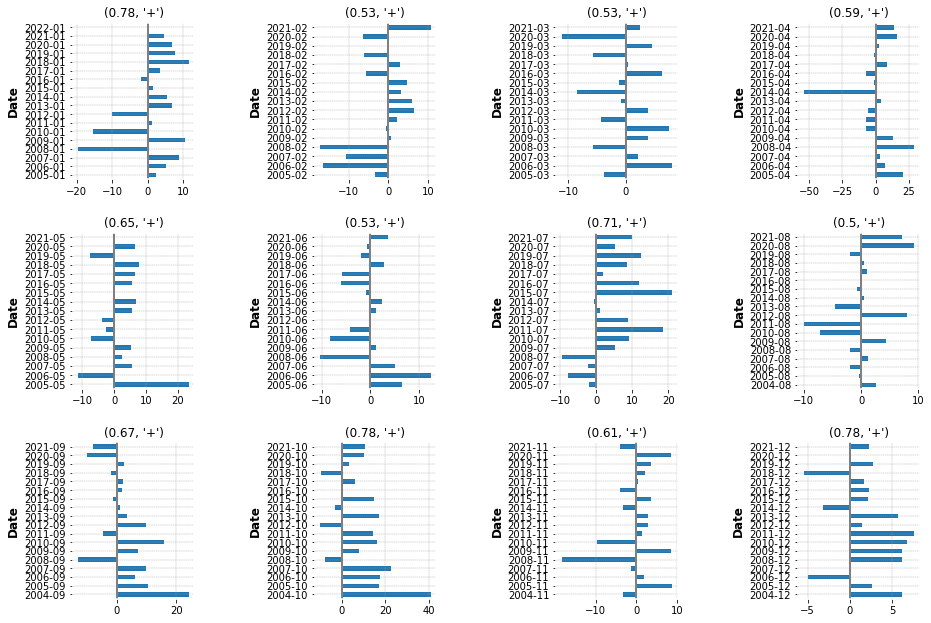

In [23]:
#@title Monthly Aggregates
# Given the 0 index begins at the most recent day, we must reverse index position in order to find the moving average.
# Because the rolling average takes the earliest index positions to calculate the moving average for numbers ahead. 
# I.E. index 0-49 calculate average for 50 we must reverse the dataframe to get the average for most recent days. 

 
df.reset_index(inplace = True)
df.rename(columns = {'date': 'Date','1. open' : 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'}, inplace = True)

# reverse
df = df.reindex(index = df.index[::-1])
df.reset_index(inplace = True, drop = True)


def percentage_change(High, Low):
    return(High - Low)

# Create 50 EMA column, and day of the week column 
df['50ema'] = df['Close'].rolling(window = 50).mean()
df['200ema'] = df['Close'].rolling(window = 200).mean()
df['DayOfWeek'] = df['Date'].dt.day_name()
df['PctChange'] = df['Close'].pct_change()*100
df['HLVolatility'] = percentage_change(df['High'], df['Low'])
df['GainLoss'] = df['PctChange']/100*df['Close']


# reverse back, and assign column in specific order
spec_order = ['GainLoss', 'DayOfWeek', 'Date', 'Open', 'Close', 'PctChange','High', 'Low','HLVolatility','50ema', '200ema', 'Volume']
df = df.reindex(index = df.index[::-1], columns = spec_order)
df.reset_index(inplace = True, drop = True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
stock_df = df.copy()
stock_df_shift = stock_df.copy()

#``````````````
# threshold of 1.01 pct change to classify bear bull openings. Then create bull, bear category on stock_df

stock_df_shift['Close'] = stock_df_shift['Close'].shift(-1)
bull_bear = 1 - (stock_df_shift['Close'][0:] / stock_df_shift['Open'][0:] )
slow_start = np.where(bull_bear < .01, 0, 1)
stock_df['bull_bear'] = slow_start

# --------
d = df.groupby(df['Date'].dt.to_period('M')).agg('sum').reset_index()
d['Date'] = d['Date'].apply(str)
d


January = d[d['Date'].str.endswith('01')].set_index('Date')
February = d[d['Date'].str.endswith('02')].set_index('Date')
March = d[d['Date'].str.endswith('03')].set_index('Date')
April = d[d['Date'].str.endswith('04')].set_index('Date')
May = d[d['Date'].str.endswith('05')].set_index('Date')
June = d[d['Date'].str.endswith('06')].set_index('Date')
July = d[d['Date'].str.endswith('07')].set_index('Date')
August = d[d['Date'].str.endswith('08')].set_index('Date')
September = d[d['Date'].str.endswith('09')].set_index('Date')
October = d[d['Date'].str.endswith('10')].set_index('Date')
November = d[d['Date'].str.endswith('11')].set_index('Date')
December = d[d['Date'].str.endswith('12')].set_index('Date')

def check(frame):
    k = 0
    count = 0
    for num in frame['PctChange']:
        if num > k:
            count += 1
    x = round(count/len(frame['PctChange']),2)
    return(x, '+')
# ---------

frames = [January, February, March, April, May, June, July, August, September, October, November, December]


def graphs(month):
    month['PctChange'].plot(kind = 'barh', figsize = (12, 10))
    plt.title(check(month))
    plt.axvline(x = 0, color = '.5')
    plt.subplots_adjust(left = 0.3)

plt.subplot(3,4,1)   
graphs(January)
plt.subplot(3,4,2)
graphs(February)
plt.subplot(3,4,3)
graphs(March)
plt.subplot(3,4,4)
graphs(April)
plt.subplot(3,4,5)
graphs(May)
plt.subplot(3,4,6)
graphs(June)
plt.subplot(3,4,7)
graphs(July)
plt.subplot(3,4,8)
graphs(August)
plt.subplot(3,4,9)
graphs(September)
plt.subplot(3,4,10)
graphs(October)
plt.subplot(3,4,11)
graphs(November)
plt.subplot(3,4,12)
graphs(December)
plt.subplots_adjust(left=0.01,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.99, 
                    hspace=0.34)


print(sym, 'Plots by Monthly % Change ')

In [24]:
#@title Filter Data by Relation to 200 EMA & Group Daily Percentage Changes  

def narrow_down_between(n, n_2):
    if n > 0:
        movement = stock_df.loc[(stock_df['PctChange'] >= n) & (stock_df['PctChange'] <= n_2)]
    else:
        movement = stock_df.loc[(stock_df['PctChange'] <= n) & (stock_df['PctChange'] >= n_2)]

        
    EMA_relation = stock_df['Close'].iloc[0] - stock_df['200ema'].iloc[0]
    if EMA_relation < 0:
        movement = movement.loc[movement['200ema']* 1.05 > movement['Close']]
    else:
        movement = movement.loc[movement['200ema'] < movement['Close']]
            
    movement_copy = movement.copy()
    movement_copy['Date'] = movement_copy['Date'].astype(str).str[5:7]
    movement_copy['Date'] = movement_copy['Date'].astype(int)
    global frequent_months 
    frequent_months = movement_copy['Date'].value_counts()
    
    bl_list = movement['Date'].to_list()
    return(bl_list)


# # --------------------

def narrow_down(n):

    if n > 0:
        movement = stock_df.loc[stock_df['PctChange'] > n] 
    else:
        movement = stock_df.loc[stock_df['PctChange'] < n]

        
    EMA_relation = stock_df['Close'].iloc[0] - stock_df['200ema'].iloc[0]
    if EMA_relation < 0:
        movement = movement.loc[movement['200ema'] > movement['Close']]
    else:
        movement = movement.loc[movement['200ema'] < movement['Close']]
    
    
    movement_copy = movement.copy()
    movement_copy['Date'] = movement_copy['Date'].astype(str).str[5:7]
    movement_copy['Date'] = movement_copy['Date'].astype(int)
    global frequent_months 
    frequent_months = movement_copy['Date'].value_counts()
        
       
    bl_list = movement['Date'].to_list()
    return(bl_list)    
    
# change this to the 1.05 percent . 
EMA_relation = round(stock_df['Close'].iloc[0] - stock_df['200ema'].iloc[0],2)
if EMA_relation < 0:
    print('\nFiltering for instances below 200 day moving average with 5 percent leniency. Close price was ' + str(EMA_relation)+ ' below the mark')
else:
    print(str(EMA_relation) + ' dollars above the 200 day moving average. Filtering for all historical instances above the mark' )

275.3 dollars above the 200 day moving average. Filtering for all historical instances above the mark


In [25]:
#@title Monthly Volatility Weightings Based on Percentage Change Frequencies

# specify instances of percentage changes in specific intervals. Takes into 
# account relation to EMA.

n_one = -6.01
run_one = narrow_down(n_one)
frequent_month_one = frequent_months.to_frame(name = n_one)

n_two = -3.01
top = -6
run_two = narrow_down_between(n_two, top)
frequent_month_two = frequent_months.to_frame(name = n_two)

n_three = -1.01
top = -3
run_three = narrow_down_between(n_three, top)
frequent_month_three = frequent_months.to_frame(name = n_three)

n_four = 0
top = -1
run_four = narrow_down_between(n_four, top)
frequent_month_four = frequent_months.to_frame(name = n_four)

n_five = 0.1
top = 1
run_five = narrow_down_between(n_five, top)
frequent_month_five = frequent_months.to_frame(name = n_five)

n_six = 1.01
top = 3
run_six = narrow_down_between(n_six, top)
frequent_month_six = frequent_months.to_frame(name = n_six)

n_seven = 3.01
top = 6
run_seven = narrow_down_between(n_seven, top)
frequent_month_seven = frequent_months.to_frame(name = n_seven)

n_eight = 6.01
run_eight = narrow_down(n_eight)
frequent_month_eight = frequent_months.to_frame(name = n_eight)

# -----------------

given_freq = pd.concat([frequent_month_one, frequent_month_two, frequent_month_three, frequent_month_four, frequent_month_five, frequent_month_six, frequent_month_seven, frequent_month_eight], axis = 1)
dic = { 1 : 'January' , 2: 'February', 3: 'March', 4 : 'April', 5: 'May', 6 : 'June', 7: 'July', 8: 'August', 9 : 'September', 10 : 'October' , 11 : 'November', 12:  'December'}

given_freq = given_freq.rename(index = dic)
given_freq = given_freq.replace(np.nan, 0)
given_freq = given_freq.astype(int)

# # give scaled ratings to the frequencies.
# given_freq[n_one] = given_freq[n_one] * 3
# given_freq[n_two] = given_freq[n_two] * 2

# given_freq[n_eight] = given_freq[n_seven] * 2
# given_freq[n_seven] = given_freq[n_eight] * 3


given_freq['NEG_VOLATILITY'] = -((given_freq[n_one]*3 + given_freq[n_two]*2 + given_freq[n_three]) + (given_freq[n_four]))
given_freq['POS_VOLATILITY'] = (given_freq[n_five] + given_freq[n_six] + given_freq[n_seven]*2 + given_freq[n_eight]*3)
given_freq['WEIGHTING'] = (given_freq['NEG_VOLATILITY'] + given_freq['POS_VOLATILITY'])
scaler = MinMaxScaler(feature_range = (0,10))
given_freq ['WEIGHTING'] = scaler.fit_transform(given_freq['WEIGHTING'].values.reshape(-1,1))

column_names = [str(n_one) + ' & less', str(n_one)+ ' to ' + str(n_two), str(n_two) + ' to ' + str(n_three), str(n_three) + ' to ' + str(n_four), str(n_five) + ' to '  + str(n_six), str(n_six) + ' to '  + str(n_seven), str(n_seven) + ' to '  + str(n_eight), str(n_eight) + ' & above' , 'NEG_VOLATILITY','POS_VOLATILITY', 'WEIGHTING']
given_freq.columns = column_names

given_freq

given_freq.sort_values(by = 'WEIGHTING', ascending = False)

# n_one = -6.01
# n_two = -3.01
# n_three = -1.01
# n_four = 0
# n_five = 0.1
# n_six = 1.01
# n_seven = 3.01
# n_eight = 6.01

# bigger jumps have different weightings 

,-6.01 & less,-6.01 to -3.01,-3.01 to -1.01,-1.01 to 0,0.1 to 1.01,1.01 to 3.01,3.01 to 6.01,6.01 & above,NEG_VOLATILITY,POS_VOLATILITY,WEIGHTING
October,1,2,44,78,82,64,13,4,-129,184,10.00
July,0,5,37,59,72,50,9,3,-106,149,8.36
February,2,15,22,58,82,38,5,2,-116,136,5.21
April,2,5,25,67,63,45,8,1,-108,127,5.07
May,0,5,34,67,63,52,5,0,-111,125,4.38
January,2,8,46,63,63,52,13,1,-131,144,4.25
March,0,5,46,80,72,51,11,1,-136,148,4.11
September,0,4,39,75,64,60,3,0,-122,130,3.56
November,0,8,45,82,69,66,5,1,-143,148,3.15
December,0,1,33,106,87,59,0,0,-141,146,3.15


In [26]:
#@title Chance of Accomplishing Gain Based on Frequency

# define the function

span = 25
limit = 5


def get_data(run):
    list_len = len(run)
    i = 0
    while i < list_len:
        start = run[i]
        end = start + pd.tseries.offsets.BusinessDay(n = span)
        end = str(end)[0:10]
        day_before = start - DateOffset(days = 0)
        day_before = str(day_before)[0:10]
        row_zero = stock_df[stock_df['Date'].astype(str).str[:10] == day_before]
        start = str(start)[0:10]
        query = stock_df[(stock_df['Date'] >= (start)) & (stock_df['Date'] <= (end))] 
        query = query.reindex(index = query.index[::-1])
        query.reset_index(inplace = True, drop = True)
        df = pd.concat([row_zero, query], ignore_index=True)
        
        begin_price.append(df['Close'].iloc[0])
        peak_num = df['Close'].max()
        min_num = df['Close'][0]
        gain = round(peak_num - min_num,2)
     
        if gain == 0:
            min_num = df['Close'].iloc[-1]
            gain = round(min_num - peak_num,2)
        else:
            pass
        gain_list.append(gain)
    
        initial_date = df.loc[df['Close']==peak_num]
        peak_date = []
        for stuff in initial_date['Date']:
            peak_date.append(stuff)
            
        peak_date_vars = pd.DataFrame(peak_date, columns = ['peak_dates'])   #change a list to a dataframe 
        begin_date = df['Date'].iloc[0]      # begin_date as a string, end is already a string in function.
        begin_date = str(begin_date)[0:10]    
        peak_date_vars['peak_dates'] = peak_date_vars['peak_dates'].apply(str)     # change datetime to strings
        peak_date_vars['peak_dates'] = peak_date_vars['peak_dates'].str.slice(0,10) # slice the strings 
        peak_date_vars.loc[peak_date_vars['peak_dates'] == begin_date, 'peak_dates'] = end  #located bad peak_dates 
        peak_date_vars['peak_dates'] = peak_date_vars['peak_dates'].apply(pd.to_datetime) # change back to datetime     
        begin_date = df['Date'].iloc[0]
        num_of_days = peak_date_vars['peak_dates'][0] - begin_date
        date_list.append(num_of_days)
        i +=1
    return(gain_list, date_list, begin_price)


# ------------ run one

gain_list = []
date_list = []
begin_price = []

gain_list, date_list, begin_price =get_data(run_one)   

def follow_up():
    df_scat = pd.DataFrame(list(zip(gain_list, date_list, begin_price)),
            columns = ['gains', 'time_elapsed', 'begin_price'])
    df_scat = df_scat.sort_values(by = ['time_elapsed'], ascending = True, ignore_index = True)
    df_scat['time_elapsed'] = df_scat['time_elapsed'].astype(str)
    df_scat['ratio'] = df_scat['gains'] / df_scat['begin_price'] * 100
    
    low_gains = df_scat['ratio'].loc[df_scat['ratio'] <= limit].values
    chance_of_gain_one = round(100-(len(low_gains)/len(df_scat)*100),2)
    
    return(chance_of_gain_one, df_scat)    

chance_of_gain_one, df_scat = follow_up()

    
# --------- run two

gain_list = []
date_list = []
begin_price = []

gain_list, date_list, begin_price =get_data(run_two)   

chance_of_gain_two, df_scat = follow_up()


# # ---------run three

gain_list = []
date_list = []
begin_price = []

gain_list, date_list, begin_price =get_data(run_three)   

chance_of_gain_three, df_scat = follow_up()

# # ---------run four

gain_list = []
date_list = []
begin_price = []

gain_list, date_list, begin_price =get_data(run_six)   

chance_of_gain_six, df_scat = follow_up()

# # ------------- run five

gain_list = []
date_list = []
begin_price = []

gain_list, date_list, begin_price =get_data(run_seven)   

chance_of_gain_seven, df_scat = follow_up()

# # ------------- run six

gain_list = []
date_list = []
begin_price = []

gain_list, date_list, begin_price =get_data(run_eight)   

chance_of_gain_eight, df_scat = follow_up()

# # ------------
# # success rate is classified as 1 percent return within the timeframe. 
data = {'Daily_Pct_Changes' : [str(n_one) + ' & less', str(n_one)+ ' to ' + str(n_two), str(n_two) + ' to ' + str(n_three), str(n_six) + ' to ' + str(n_seven), str(n_seven) + ' to '  + str(n_eight), str(n_eight) + ' & above'], 
        'Chance_of_Gain' : [chance_of_gain_one, chance_of_gain_two, chance_of_gain_three, chance_of_gain_six, chance_of_gain_seven, chance_of_gain_eight],
         'Total_Records' : [len(run_one), len(run_two), len(run_three), len(run_six), len(run_seven), len(run_eight)]}

frame = pd.DataFrame(data)

# # when below 200 day EMA chances of continuous loss is much lower. 

print('Classification for chance of gain is minimum ' + str(limit) + ' percent increase over ' + str(span) + ' days')

EMA_relation = round(stock_df['Close'].iloc[0] - stock_df['200ema'].iloc[0],2)
if EMA_relation < 0:
    print('\nAll records below 200 day moving average. ')
else:
    print('\nAll records above 200 day moving average. ' )

frame


Classification for chance of gain is minimum 5 percent increase over 25 days

All records above 200 day moving average. 


,Daily_Pct_Changes,Chance_of_Gain,Total_Records
0,-6.01 & less,28.57,7
1,-6.01 to -3.01,51.43,70
2,-3.01 to -1.01,54.67,428
3,1.01 to 3.01,54.68,631
4,3.01 to 6.01,53.85,78
5,6.01 & above,35.71,14


positive mean % gain: 10.1
positive median % gain: 8.12

345 positive accounts out of 631
Threshold is 5 percent increase over 25 days


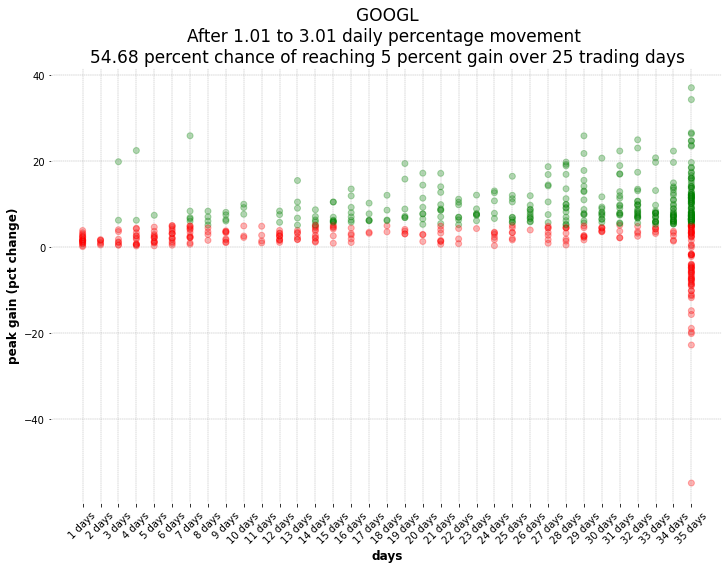

In [28]:
#@title Scatter Plot 

if frame.iloc[0]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    gain_list = []
    date_list = []
    begin_price = []
    
    gain_list, date_list, begin_price =get_data(run_one) 
    
    chance_of_gain_one, df_scat = follow_up()
    
    plug_chance = chance_of_gain_one
    plug_pct = (str(n_one) + ' & less')
    
elif frame.iloc[1]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    gain_list = []
    date_list = []
    begin_price = []
    
    gain_list, date_list, begin_price =get_data(run_two) 
    
    chance_of_gain_two, df_scat = follow_up()
    
    plug_chance = chance_of_gain_two
    plug_pct = (str(n_one)+ ' to ' + str(n_two))
    
elif frame.iloc[2]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    gain_list = []
    date_list = []
    begin_price = []    
    
    gain_list, date_list, begin_price =get_data(run_three)  
    
    chance_of_gain_three, df_scat = follow_up()
    
    plug_chance = chance_of_gain_three
    plug_pct = (str(n_two) + ' to ' + str(n_three))
    
elif frame.iloc[3]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    gain_list = []
    date_list = []
    begin_price = []
    gain_list, date_list, begin_price =get_data(run_six)  
    
    chance_of_gain_six, df_scat = follow_up()
    
    plug_chance = chance_of_gain_six
    plug_pct = (str(n_six) + ' to ' + str(n_seven))

elif frame.iloc[4]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    gain_list = []
    date_list = []
    begin_price = []
    gain_list, date_list, begin_price =get_data(run_seven) 
    
    chance_of_gain_seven, df_scat = follow_up()
    
    plug_chance = chance_of_gain_seven
    plug_pct = (str(n_seven) + ' to '  + str(n_eight))
else:
    gain_list = []
    date_list = []
    begin_price = []
    gain_list, date_list, begin_price =get_data(run_eight)
    
    chance_of_gain_eight, df_scat = follow_up()
    
    plug_chance = chance_of_gain_eight
    plug_pct = (str(n_eight) + ' & above')
    
loss_chance =  sym+'\nAfter '+ str(plug_pct)+ ' daily percentage movement \n'+ str(plug_chance) + ' percent chance of reaching '+ str(limit) + ' percent gain over '+str(span)+' trading days'

x = df_scat['time_elapsed'].values
y = df_scat['ratio'].values 

my_color = np.where(y>= limit, 'green', 'red')


plt.figure(figsize=(12,8))
plt.scatter(x, y, c = my_color, alpha = 0.3)
plt.title(loss_chance, fontsize = 17)
plt.xlabel('days')
plt.ylabel('peak gain (pct change)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show;

greater = df_scat.loc[df_scat['ratio'] >= limit]
greater_mean = (greater['ratio'].mean())
greater_mean = (round(greater_mean,2))
greater_median = (greater['ratio'].median())
greater_median = (round(greater_median, 2))

print('positive mean % gain: ' + str(greater_mean))
print('positive median % gain: ' + str(greater_median) + '\n')
print(str(len(greater)) + ' positive accounts out of ' + str(len(df_scat)))
print('Threshold is ' + str(limit) + ' percent increase over ' + str(span) + ' days')


Peak gain after 1.01 to 3.01 percent movement
2021-12-31


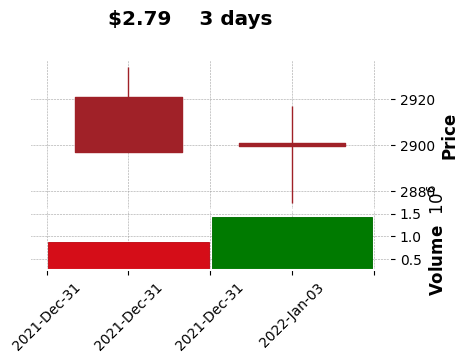

2021-12-30


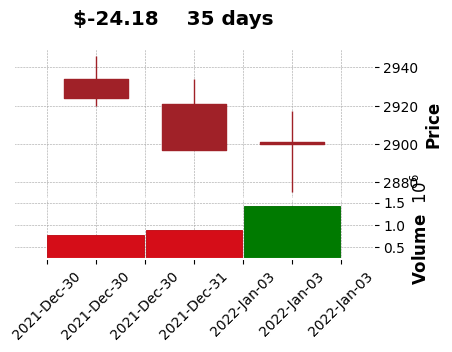

2021-12-29


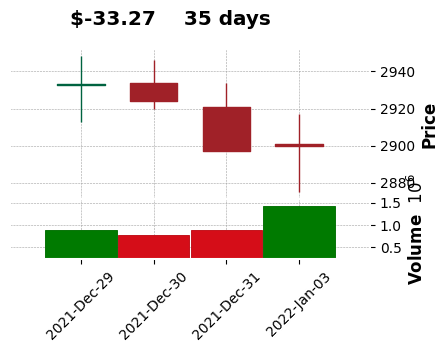

2021-12-28


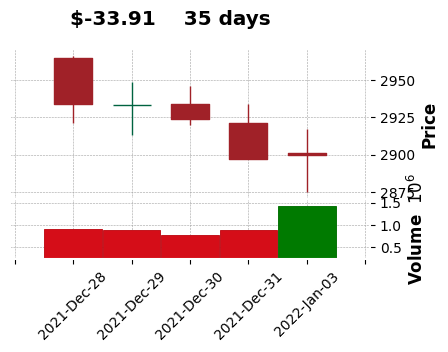

2021-12-20


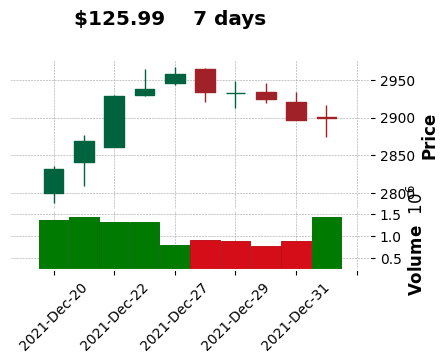

2021-12-09


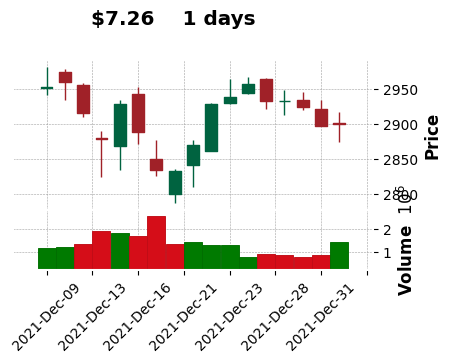

2021-12-03


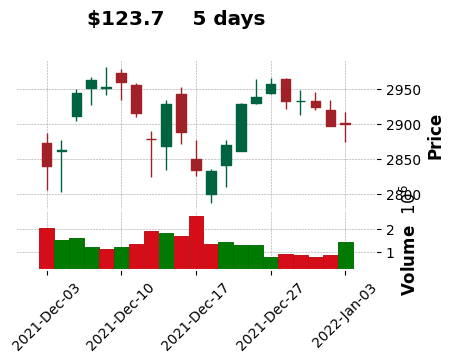

2021-12-01


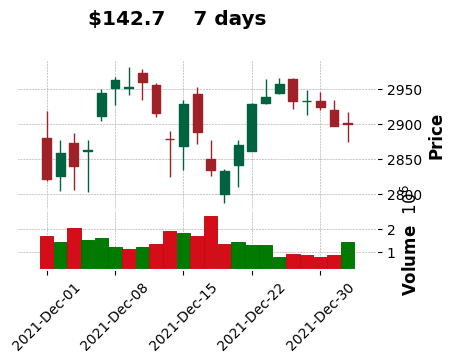

2021-11-23


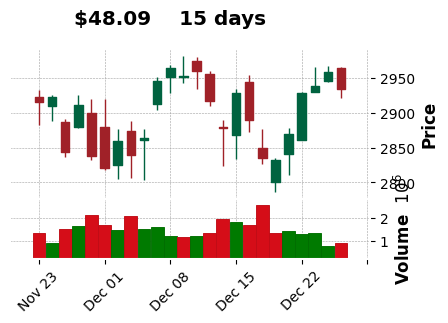

2021-11-19


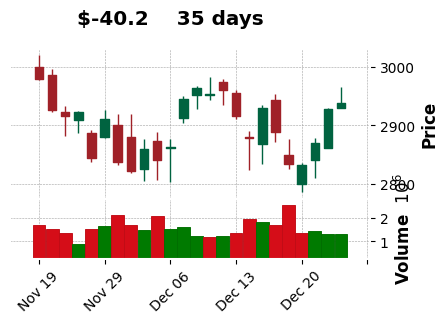

2021-11-16


KeyboardInterrupt: ignored

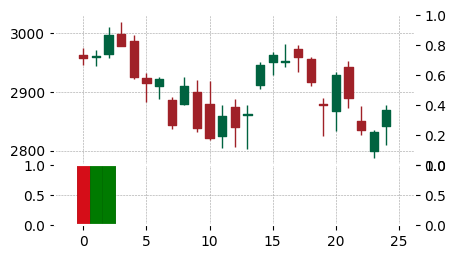

In [29]:
#@title Historical Instances

# creating graphs source 
# https://openwritings.net/pg/mplfinance/python-draw-candlestickohlc-using-new-mplfinance 

def get_graphs(run):
    list_len = len(run)
    i = 0
    while i < list_len:
        start = run[i]
        end = start + pd.tseries.offsets.BusinessDay(n = span)
        end = str(end)[0:10]
        day_before = start - DateOffset(days = 0)
        day_before = str(day_before)[0:10]
        row_zero = stock_df[stock_df['Date'].astype(str).str[:10] == day_before]
        start = str(start)[0:10]
        query = stock_df[(stock_df['Date'] >= (start)) & (stock_df['Date'] <= (end))] 
        query = query.reindex(index = query.index[::-1])
        query.reset_index(inplace = True, drop = True)
        df = pd.concat([row_zero, query], ignore_index=True)
        
        peak_num = df['Close'].max()
        min_num = df['Close'][0]
        gain = round(peak_num - min_num,2)    

        if gain == 0:
            min_num = df['Close'].iloc[-1]
            gain = round(min_num - peak_num,2)
        else:
            pass       

        initial_date = df.loc[df['Close']==peak_num]
        peak_date = []
        for stuff in initial_date['Date']:
            peak_date.append(stuff)
                
        peak_date_vars = pd.DataFrame(peak_date, columns = ['peak_dates'])   #change a list to a dataframe 
        
        begin_date = df['Date'].iloc[0]      # begin_date as a string, end is already a string in function.
        begin_date = str(begin_date)[0:10]
        
        peak_date_vars['peak_dates'] = peak_date_vars['peak_dates'].apply(str)     # change datetime to strings
        peak_date_vars['peak_dates'] = peak_date_vars['peak_dates'].str.slice(0,10) # slice the strings 
        
        peak_date_vars.loc[peak_date_vars['peak_dates'] == begin_date, 'peak_dates'] = end  #located bad peak_dates 
        peak_date_vars['peak_dates'] = peak_date_vars['peak_dates'].apply(pd.to_datetime) # change back to datetime

        begin_date = df['Date'].iloc[0]
        num_of_days = (peak_date_vars.iloc[0] - begin_date)
        
        df = df[['Open', 'High', 'Low', 'Close', 'Date', 'Volume' ]]
        df = df.drop([1]).set_index('Date')
        
        print(str(run[i])[0:10])
        mpf.plot(df, type = 'candle', style = 'charles', volume = True, figsize = (5,3),
                 mav = (200), title = ('$'+str(gain)+ '    '+str(num_of_days)[13:20]))    
        i += 1

        

print( 'Peak gain after ' +str(plug_pct)+ ' percent movement')


if frame.iloc[0]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    get_graphs(run_one) 
elif frame.iloc[1]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    get_graphs(run_two)
elif frame.iloc[2]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    get_graphs(run_three)
elif frame.iloc[3]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    get_graphs(run_four)
elif frame.iloc[4]['Chance_of_Gain'] == frame['Chance_of_Gain'].max():
    get_graphs(run_five)
else:
    gain_list, date_list, begin_price =get_data(run_six)
    get_graphs(run_six)

In [30]:
#@title Bear Bull Pre-Market Observation / Mount to Drive 

# take open stock price and compare it to yesterdays close, which classifies bear_bull
# at a threshold of 1% increase. 

warnings.simplefilter(action = 'ignore', category = SettingWithCopyWarning)


from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Stock_Market_CSVs/


df_low = pd.read_csv(sym + '_low_intraday.csv')
df_low.drop_duplicates(inplace = True)
df_low.drop([1], inplace = True)
df_low['DayOfWeek'] = df_low['Day_of_the_Week'].str.upper()


def merge_func(daily_df, intraday_df):
    daily_df['Date'] = daily_df['Date'].astype(str)
    intraday_df['time'] = intraday_df['time'].astype(str)
    
    sauce = []
    times = []

    for stuff in intraday_df['time']:
        sauce.append(stuff)
    for stuff in sauce:
        times.append(stuff[0:10])

    intraday_df['Date'] = times
    merged_df = pd.merge(daily_df, intraday_df, on= 'Date')
    merged_df['time'] = merged_df['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    merged_df = merged_df[['time', 'PctChange', 'open', 'close','high', 'low','volume','bull_bear']]
    return(merged_df)


merged_df = merge_func(stock_df, df_low)
# ---------

merged_df['time'] = merged_df['time'].astype(str)
    
sauce = []
times = []

for stuff in merged_df['time']:
    sauce.append(stuff)
for stuff in sauce:
    times.append(stuff[0:10])

merged_df['Date'] = times
merged_df = merged_df.groupby('bull_bear')

merged_df


bull_pres = merged_df.get_group(1)
bear_pres = merged_df.get_group(0)

#--------
bull_pres = bull_pres['Date'].drop_duplicates().to_list()
bear_pres = bear_pres['Date'].drop_duplicates().to_list()

stock_df = stock_df.set_index('Date')
bull_pres = stock_df.loc[bull_pres]
bear_pres = stock_df.loc[bear_pres]

#-------

bear_average = round((bear_pres['PctChange'].mean()),2)
bull_average = round((bull_pres['PctChange'].mean()),2)

finish_above_bear = round((sum(bear_pres['PctChange'] > 1)-1) / len(bear_pres)*100,2)
finish_above_bull = round((sum(bull_pres['PctChange'] > 1)-1) / len(bull_pres)*100,2)

print(str(finish_above_bull) + ' % of the time bull openings return over 1% \nfor an average return of '+str(bull_average)+'%')
print('\n\n' + str(finish_above_bear) + ' % of the time bear openings return over 1% \nfor an average return of ' + str(bear_average)+'%')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Stock_Market_CSVs
60.0 % of the time bull openings return over 1% 
for an average return of 1.72%


19.48 % of the time bear openings return over 1% 
for an average return of -0.04%


Type in the specific day to filter : Monday


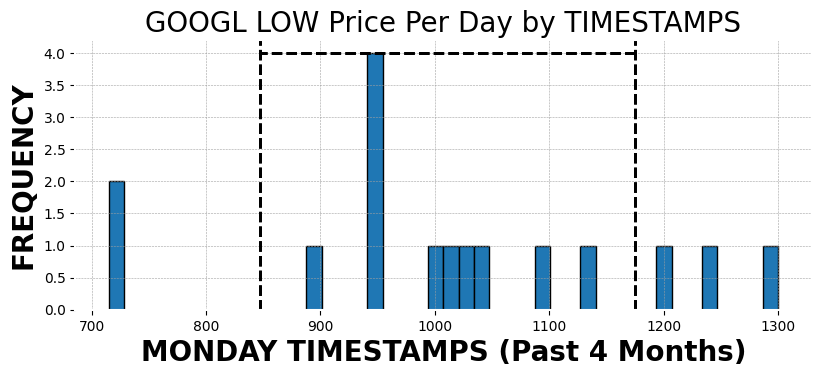

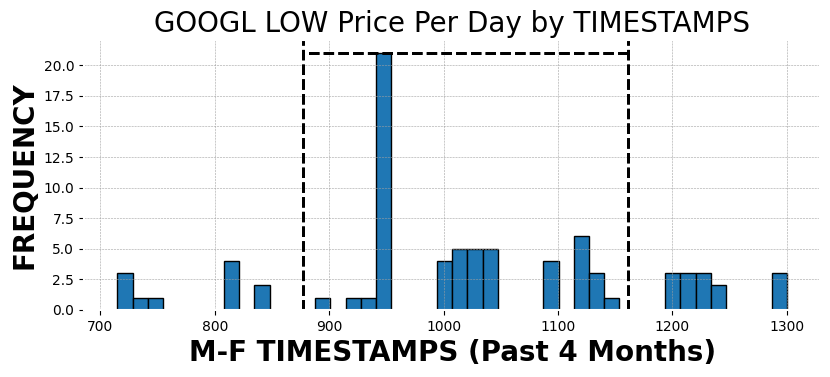

In [31]:
#@title Intraday Timestamps Lows 
sym = sym.upper()

df_low = pd.read_csv(sym + '_low_intraday.csv')
df_low.drop_duplicates(inplace = True)
df_low.drop([1], inplace = True)
df_low['DayOfWeek'] = df_low['Day_of_the_Week'].str.upper()


day = input('Type in the specific day to filter : ').upper()

day_filt = df_low['DayOfWeek'] == day
spec_day = df_low.loc[day_filt].reset_index(drop=True)

spec_day = spec_day.drop(labels = ['open', 'high', 'low', 'close', 'volume'], axis = 1)

spec_day

sauce = []
times = []

for stuff in spec_day['time']:
    sauce.append(stuff)
for stuff in sauce:
    times.append(stuff[11:16])
            
            
altered = ([s.replace(':', '') for s in times])
new_alter = [int(i) for i in altered]

spec_day = pd.DataFrame(new_alter)
spec_day.plot.hist(bins = 44, legend = False, edgecolor = 'black')

fig = plt.gcf()
fig.set_size_inches(9.5, 3.5)


plt.xlabel(day + ' TIMESTAMPS (Past 4 Months)', fontsize = 20)
plt.ylabel('FREQUENCY', fontsize = 20)
plt.title(sym + ' LOW Price Per Day by TIMESTAMPS', fontsize = 20)


def get_standard(df_col):
    std = stdev(df_col[0])
    mn = mean(df_col[0])
    upper_68 = round(mn+std)
    lower_68 = mn-std
    mx = spec_day.value_counts().max()
    global xcoordz
    xcoordz = [upper_68, lower_68, mx]
    
get_standard(spec_day)


for xc in xcoordz:
    plt.axvline(x = xcoordz[0], color = 'k', linestyle = '--')
    plt.axvline(x = xcoordz[1], color = 'k', linestyle = '--')
    plt.plot((xcoordz[0], xcoordz[1]), (xcoordz[2], xcoordz[2]), linestyle = '--', color = 'k');

# -------------
sauce = []
times = []

for stuff in df_low['time']:
    sauce.append(stuff)
for stuff in sauce:
    times.append(stuff[11:16])
            
altered = ([s.replace(':', '') for s in times])
new_alter = [int(i) for i in altered]

df_low = pd.DataFrame(new_alter)

df_low.plot.hist(bins = 44, legend = False, edgecolor = 'black')

fig = plt.gcf()
fig.set_size_inches(9.5, 3.5)

plt.xlabel('M-F TIMESTAMPS (Past 4 Months)', fontsize = 20)
plt.ylabel('FREQUENCY', fontsize = 20)
plt.title(sym +' LOW Price Per Day by TIMESTAMPS', fontsize = 20)

def get_standard(df_col):
    std = stdev(df_col[0])
    mn = mean(df_col[0])
    upper_68 = round(mn+std)
    lower_68 = mn-std
    mx = df_low.value_counts().max()
    global xcoordz
    xcoordz = [upper_68, lower_68, mx]

get_standard(df_low)


for xc in xcoordz:
    plt.axvline(x = xcoordz[0], color = 'k', linestyle = '--')
    plt.axvline(x = xcoordz[1], color = 'k', linestyle = '--')
    plt.plot((xcoordz[0], xcoordz[1]), (xcoordz[2], xcoordz[2]), linestyle = '--', color = 'k');


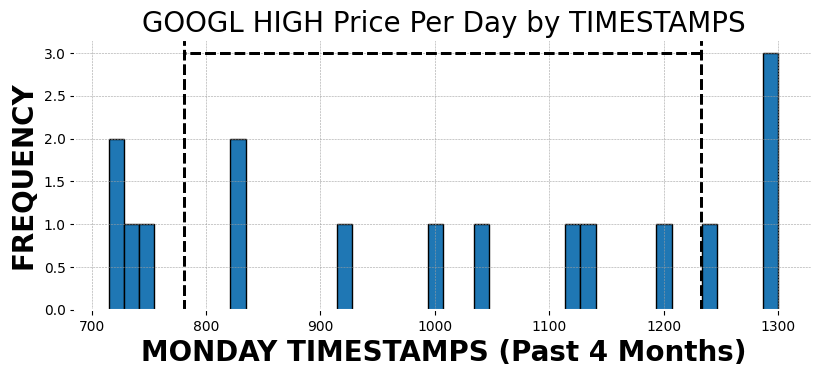

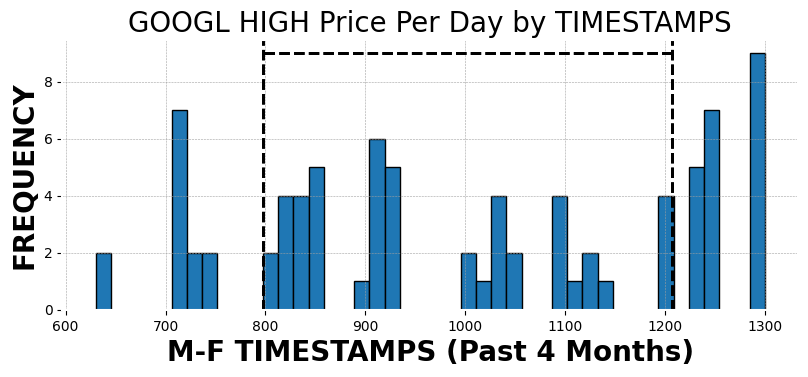

In [32]:
#@title Intraday Timestamp Highs
df_high = pd.read_csv(sym + '_high_intraday.csv')
df_high.drop_duplicates(inplace = True)
df_high.drop([1], inplace = True)
df_high['DayOfWeek'] = df_high['Day_of_the_Week'].str.upper()


day_filt = df_high['DayOfWeek'] == day
spec_day = df_high.loc[day_filt].reset_index(drop=True)

spec_day = spec_day.drop(labels = ['open', 'high', 'low', 'close', 'volume'], axis = 1)


sauce = []
times = []

for stuff in spec_day['time']:
    sauce.append(stuff)
for stuff in sauce:
    times.append(stuff[11:16])
            
altered = ([s.replace(':', '') for s in times])
new_alter = [int(i) for i in altered]

spec_day = pd.DataFrame(new_alter)


spec_day.plot.hist(bins = 44, legend = False, edgecolor = 'black')

fig = plt.gcf()
fig.set_size_inches(9.5, 3.5)


plt.xlabel(day + ' TIMESTAMPS (Past 4 Months)', fontsize = 20)
plt.ylabel('FREQUENCY', fontsize = 20)
plt.title(sym + ' HIGH Price Per Day by TIMESTAMPS', fontsize = 20);

# ---------------

def get_standard(df_col):
    std = stdev(df_col[0])
    mn = mean(df_col[0])
    upper_68 = round(mn+std)
    lower_68 = mn-std
    mx = spec_day.value_counts().max()
    global xcoordz
    xcoordz = [upper_68, lower_68, mx]
    
get_standard(spec_day)


for xc in xcoordz:
    plt.axvline(x = xcoordz[0], color = 'k', linestyle = '--')
    plt.axvline(x = xcoordz[1], color = 'k', linestyle = '--')
    plt.plot((xcoordz[0], xcoordz[1]), (xcoordz[2], xcoordz[2]), linestyle = '--', color = 'k');

  # --------
sauce = []
times = []

for stuff in df_high['time']:
    sauce.append(stuff)
for stuff in sauce:
    times.append(stuff[11:16])
            
altered = ([s.replace(':', '') for s in times])
new_alter = [int(i) for i in altered]

df_high = pd.DataFrame(new_alter)


df_high.plot.hist(bins = 44, legend = False, edgecolor = 'black')

fig = plt.gcf()
fig.set_size_inches(9.5, 3.5)

plt.xlabel('M-F TIMESTAMPS (Past 4 Months)', fontsize = 20)
plt.ylabel('FREQUENCY', fontsize = 20)
plt.title(sym +' HIGH Price Per Day by TIMESTAMPS', fontsize = 20);

# -----

def get_standard(df_col):
    std = stdev(df_col[0])
    mn = mean(df_col[0])
    upper_68 = round(mn+std)
    lower_68 = mn-std
    mx = df_high.value_counts().max()
    global xcoordz
    xcoordz = [upper_68, lower_68, mx]
    
get_standard(df_high)


for xc in xcoordz:
    plt.axvline(x = xcoordz[0], color = 'k', linestyle = '--')
    plt.axvline(x = xcoordz[1], color = 'k', linestyle = '--')
    plt.plot((xcoordz[0], xcoordz[1]), (xcoordz[2], xcoordz[2]), linestyle = '--', color = 'k');


In [33]:
#@title Analyze Given Month
question = input("Would you like to search within a certain range date? Y/N " ).upper()

for ans in question:
    if ans == 'Y':
        year_begin = input("What is your start date in YYYY-MM-DD format : ")
        date_time_obj = datetime.strptime(year_begin, '%Y-%m-%d')
        year_end = input("What is your end date in YYYY-MM-DD format : ")
        date_time_obj_2 = datetime.strptime(year_end, '%Y-%m-%d')
    else:
        pass

   
month_dict = {
    "january" : 1,
    "february" : 2,
    "march" : 3,
    "april" : 4,
    "may" : 5,
    "june" : 6,
    "july" : 7,
    "august" : 8,
    "september" : 9,
    "october" : 10,
    "november" : 11,
    "december" : 12
}

n = input('Enter a month to analyze ').lower()

month = (month_dict[n])


if ans == 'Y':
    df = df[(df['Date'] > (date_time_obj)) & (df['Date'] < (date_time_obj_2))]
else:
    pass

oo = df[df['Date'].dt.month == month]

Would you like to search within a certain range date? Y/N N
Enter a month to analyze January


In [34]:
#@title Create Monthly Dataframe 
# group by given month day of the week. 

o = oo.groupby(['DayOfWeek'])

one = o['PctChange'].agg(['median', 'mean'])
two = o['GainLoss'].agg(['median', 'mean'])
three = o['HLVolatility'].agg(['median', 'mean'])
four = o['Volume'].agg(['median', 'mean'])

df_ = pd.concat([one, two, three, four], axis = 1)


# function taken from stack overflow to give columns name in order to ultimately rename
# https://stackoverflow.com/questions/24685012/pandas-dataframe-renaming-multiple-identically-named-columns (MaxU)

cols=pd.Series(df_.columns)
for dup in df_.columns[df_.columns.duplicated(keep=False)]: 
    cols[df_.columns.get_loc(dup)] = ([dup + '.' + str(d_idx) 
                                     if d_idx != 0 
                                     else dup 
                                     for d_idx in range(df_.columns.get_loc(dup).sum())]
                                    )
df_.columns=cols
df_.rename(columns = {'median':'%_Change_Median', 'mean': '%_Change_Mean', 'median.1': 'Gain_Loss_Median', 'mean.1': 'Gain_Loss_Mean', 'median.2': 'Volatility$_Range_Median', 'mean.2': 'Volatility$_Range_Mean', 'mean.3': 'Volume_Mean', 'median.3': 'Volume_Median'}, inplace = True)
df_ = df_.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])


# ---------
# grouping specific time range of data by day, and storing in df variable. 

day_group = df.groupby(['DayOfWeek'])

DG_Daily_Change = day_group['PctChange'].agg(['median', 'mean'])
DG_Gain_Loss = day_group['GainLoss'].agg(['median', 'mean'])
DG_Volatility = day_group['HLVolatility'].agg(['median', 'mean'])
DG_Volume = day_group['Volume'].agg(['median', 'mean'])

pd.set_option('display.float_format', lambda x: '%.2f' % x)


df = pd.concat([DG_Daily_Change, DG_Gain_Loss, DG_Volatility, DG_Volume], axis = 1)

# function taken from stack overflow to give columns name in order to ultimately rename
# put link in from overflow, if adpated state it 
cols=pd.Series(df.columns)
for dup in df.columns[df.columns.duplicated(keep=False)]: 
    cols[df.columns.get_loc(dup)] = ([dup + '.' + str(d_idx) 
                                     if d_idx != 0 
                                     else dup 
                                     for d_idx in range(df.columns.get_loc(dup).sum())]
                                    )
df.columns=cols

df.rename(columns = {'median':'%_Change_Median', 'mean': '%_Change_Mean', 'mean.1': 'Gain_Loss_Mean', 'median.1': 'Gain_Loss_Median' , 'median.2': 'Volatility$_Range_Median', 'mean.2': 'Volatility$_Range_Mean', 'median.3': 'Volume_Median', 'mean.3': 'Volume_Mean'}, inplace = True)
df = df.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

comparison = pd.concat([df, df_], keys = ['All Time', n])

#@title Mount Google Drive to Access CSV Files
# from google.colab import drive
# drive.mount('/content/drive')

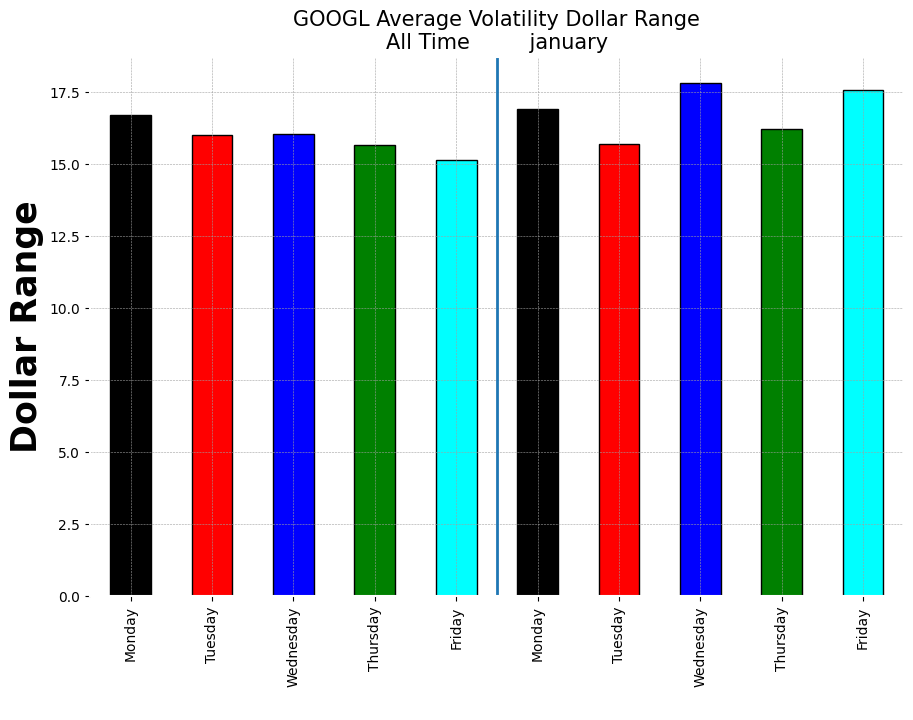

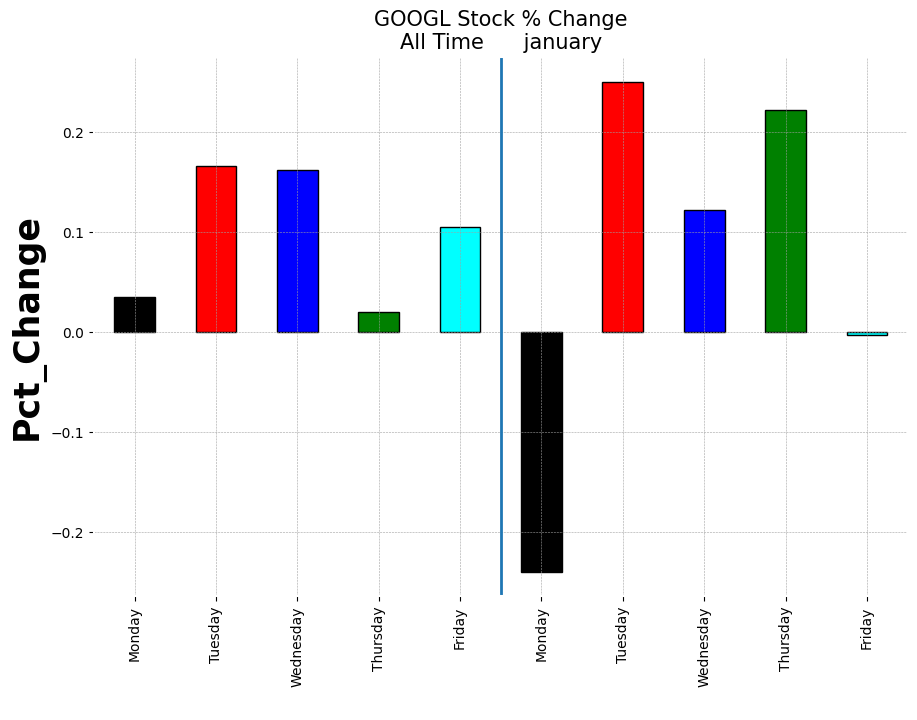

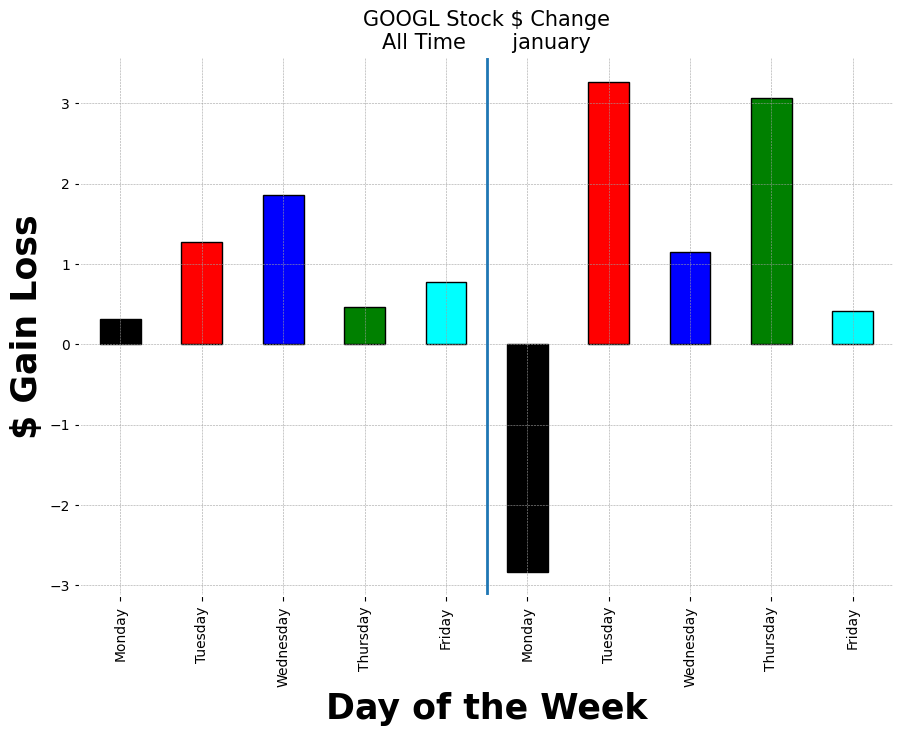

In [37]:
# from typing import Text
#@title Graphical Representation of Volatility

x = comparison.reset_index()
x.plot.bar(x = 'DayOfWeek', y='Volatility$_Range_Mean', color = ['black', 'red', 'blue', 'green', 'cyan'], legend = False, edgecolor = 'black')
fig = plt.gcf()
fig.set_size_inches(10.5, 7.0)
plt.axvline(x = 4.5)
plt.ylabel('Dollar Range', fontsize = 25)
plt.xlabel('Day of the Week', color = 'white')
plt.title(sym+ ' Average Volatility Dollar Range' + '\nAll Time         ' + n, fontsize = 15);


x.plot.bar(x = 'DayOfWeek', y='%_Change_Mean', color = ['black', 'red', 'blue', 'green', 'cyan'], legend = False, edgecolor= 'black')
fig = plt.gcf()
fig.set_size_inches(10.5, 7.0)
plt.axvline(x = 4.5)
plt.ylabel('Pct_Change', fontsize = 25)
plt.xlabel('Day of the Week', color = 'white')
plt.title(sym + ' Stock % Change' + '\nAll Time      ' + n , fontsize = 15);


x.plot.bar(x = 'DayOfWeek', y='Gain_Loss_Mean', color = ['black', 'red', 'blue', 'green', 'cyan'], legend = False, edgecolor = 'black')
fig = plt.gcf()
fig.set_size_inches(10.5, 7.0)
plt.axvline(x = 4.5)
plt.ylabel('$ Gain Loss', fontsize = 25)
plt.xlabel('Day of the Week', fontsize = 25)
plt.title(sym + ' Stock $ Change' + '\nAll Time       ' + n , fontsize = 15);

# get plt.subplots right here.